In [ ]:
! export CUDA_VISIBLE_DEVICES=2

In [1]:
from collections import OrderedDict
from utils.tokenizer import SimpleTokenizer
import models.ULIP_models as models
from main import get_args_parser
import argparse
from utils import utils
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import random

In [3]:
from ULIP_ShapeNet_Dataset.ULIP_ShapeNet import ULIP_ShapeNet

# GPU Session

In [4]:
import torch

# 打印所有可用的设备名称
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA A100-PCIE-40GB


In [5]:
# GPU_IDX = 2

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_IDX)
# print(os.environ["CUDA_VISIBLE_DEVICES"])


In [7]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

1


In [8]:
import torch

print(torch.cuda.current_device())        # 当前设备的索引
print(torch.cuda.device_count())          # 可用的设备数量
print("CUDA device name:", torch.cuda.get_device_name(0))    # 设备 0 的名称

0
1
CUDA device name: NVIDIA A100-PCIE-40GB


# Current support class

In [9]:
# Define class names and descriptions
shapenet_classes = ['plane', 'table', 'chair']

img_descriptions = []
pc_descriptions = []

for i, sn_class in enumerate(shapenet_classes):
    img_descriptions.append(f'This is an image of a 3D rendering {sn_class}')
    # img_descriptions.append(f'This is an image of a {sn_class}')
    
    pc_descriptions.append(f'This is a 3D point cloud of a {sn_class}')

print(img_descriptions)
print(pc_descriptions)

['This is an image of a 3D rendering plane', 'This is an image of a 3D rendering table', 'This is an image of a 3D rendering chair']
['This is a 3D point cloud of a plane', 'This is a 3D point cloud of a table', 'This is a 3D point cloud of a chair']


# Load the ULIP ShapeNet dataset

In [10]:
keyword = "plane"
# keyword = None

dataset = ULIP_ShapeNet(keyword=keyword)
print(len(dataset))

data, RGB_imgs_show = dataset.process_index(show_images=True)

2860


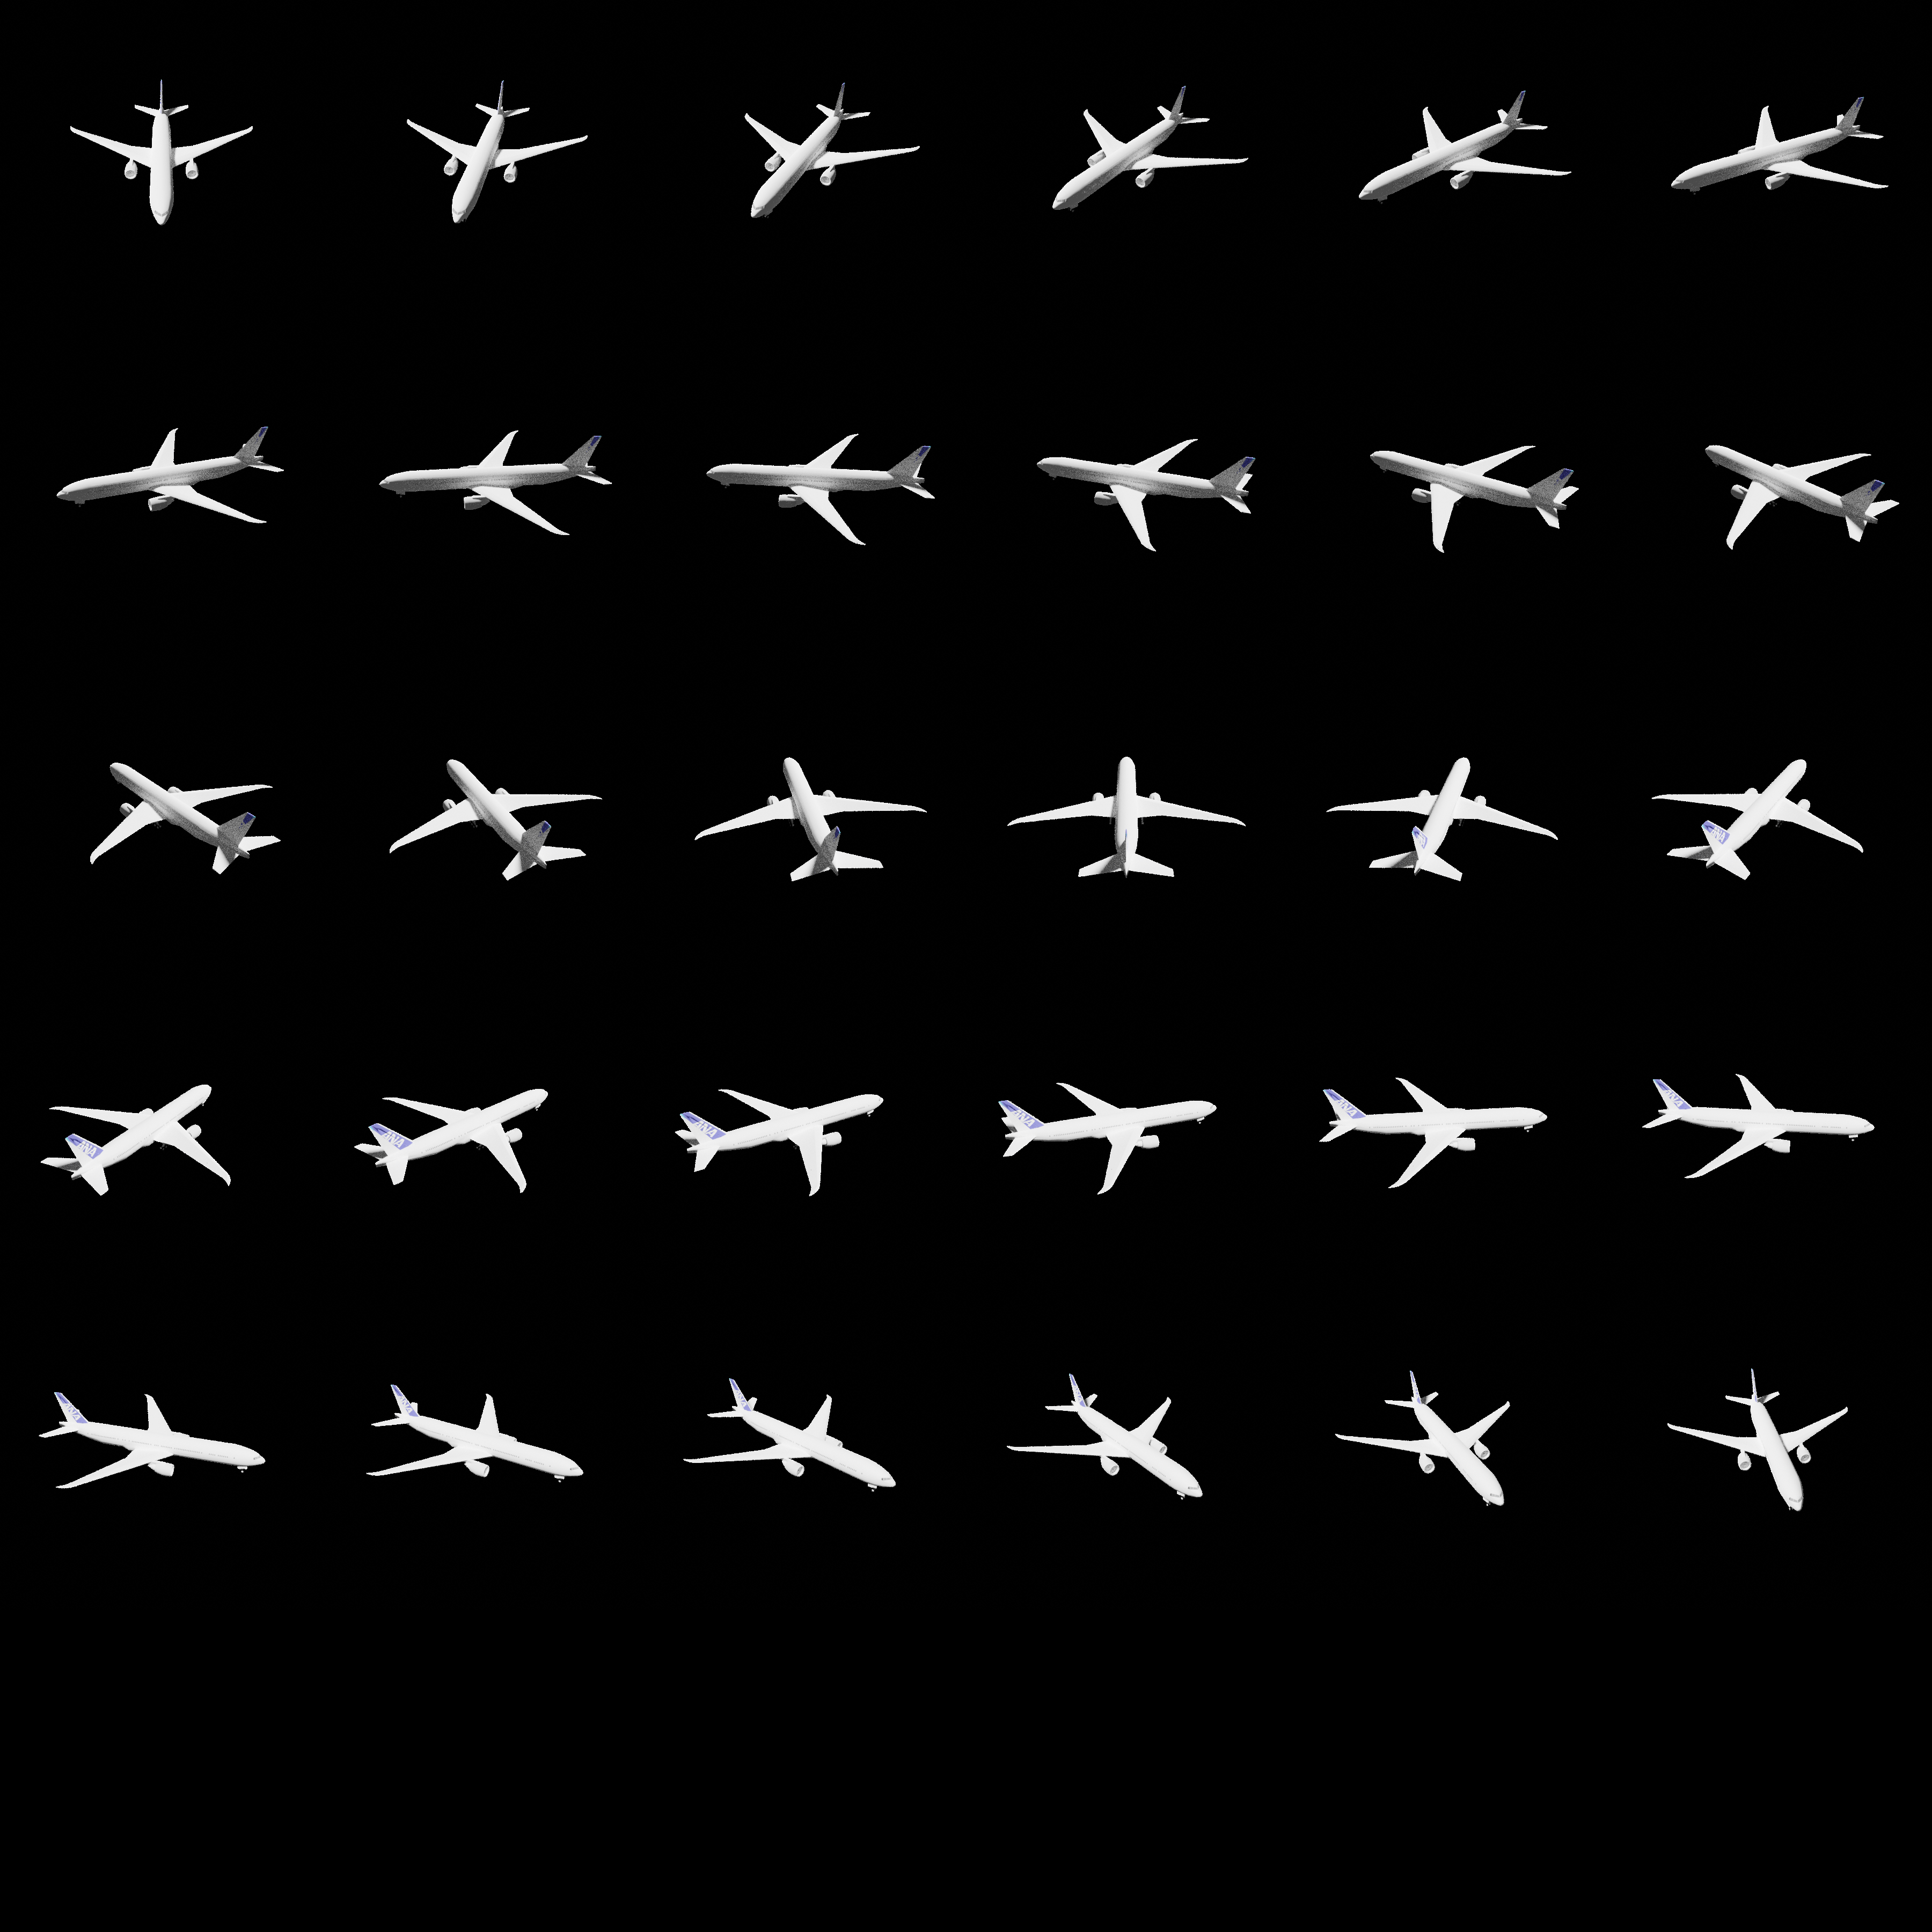

In [11]:
RGB_imgs_show

In [12]:
dataset.visualize_pointcloud(data["pointcloud_np"])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000501…

In [13]:
index_A, index_B = dataset.choose_random_angles(data, 60)

In [14]:
angle_A = data[f"angle_{index_A}"]["angle"]
image_A = data[f"angle_{index_A}"]["image"]
angle_B = data[f"angle_{index_B}"]["angle"]
image_B = data[f"angle_{index_B}"]["image"]
captions_B = data[f"angle_{index_B}"]["captions"]

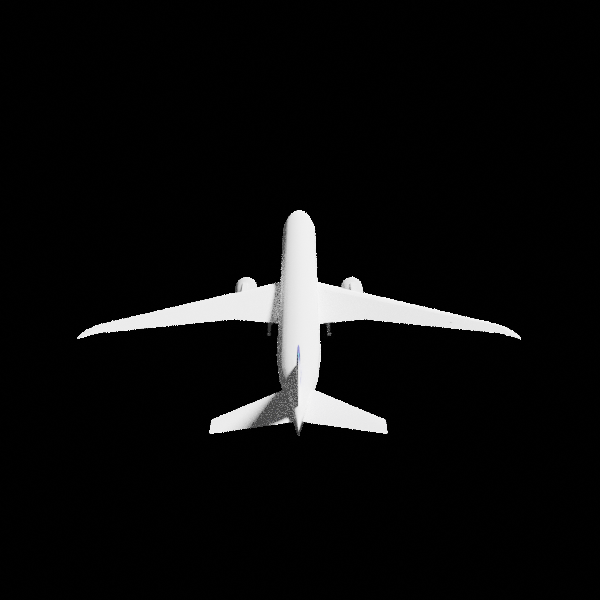

In [15]:
image_A

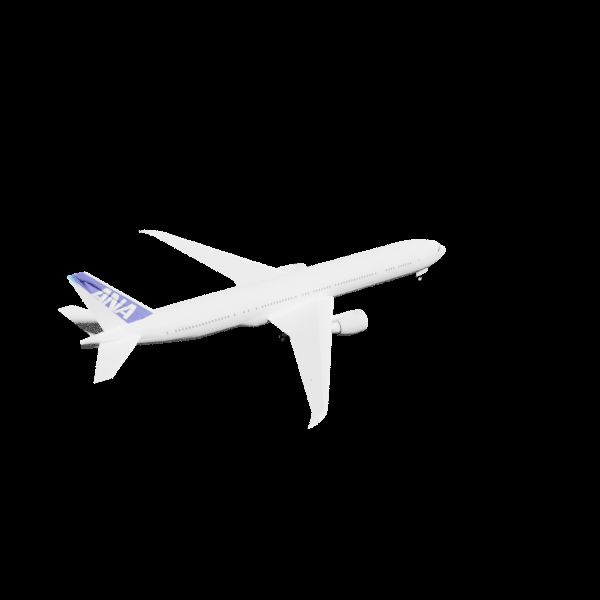

In [16]:
image_B

In [17]:
print(angle_A)
print(angle_B)
print(abs(angle_A - angle_B))

180
240
60


In [18]:
captions_B

['a white airplane is in flight and a background of grey',
 'a gray and white plane flying high in the air',
 'a plane is flying through a gray sky',
 'a 3d white airplane flying in the air',
 'the plane is flying by itself in the air',
 'a large plane with white wing tips, with blue striping is in the sky',
 'the white airplane is traveling in the gray sky',
 'a white airplane is flying through the sky',
 'an image of a jet flying through the sky',
 'the image of a plane from above']

# Load the ULIP pretrained 3D encoder and OpenCLIP

In [19]:
def create_fake_args():
    parser = argparse.ArgumentParser('ULIP training and evaluation', parents=[get_args_parser()])
    fake_args = parser.parse_args([])  # 使用空列表初始化命名空间
    # 手动设置每个参数的值
    fake_args.output_dir = './outputs'
    # fake_args.npoints = 8192
    fake_args.npoints = 10000
    fake_args.model = 'ULIP2_PointBERT_Colored'
    fake_args.gpu = 0
    # fake_args.test_ckpt_addr = './pretrained_models/pointbert_ULIP-2.pt'
    fake_args.test_ckpt_addr = './pretrained_models/ULIP-2-PointBERT-10k-colored-pc-pretrained.pt'
    fake_args.evaluate_3d_ulip2 = True
    return fake_args

args = create_fake_args()

In [20]:
ckpt = torch.load(args.test_ckpt_addr, map_location='cpu')

# 遍历状态字典并移除 'module.' 前缀
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    state_dict[k.replace('module.', '')] = v


In [21]:
# 打印处理后的状态字典
# for k, v in state_dict.items():
#     print(k, v.size())

In [22]:
print("=> creating model: {}".format(args.model))

# create the model
model = getattr(models, args.model)(args=args)
model.cuda()

print("")

=> creating model: ULIP2_PointBERT_Colored
Get openclip model:
Finished loading the openclip model.
PointTransformer_Colored model size:
32.50M



In [23]:
# load the parameters
model.load_state_dict(state_dict, strict=False)
# model.load_state_dict(state_dict, strict=True)

print("=> loaded pretrained checkpoint '{}'".format(args.test_ckpt_addr))

=> loaded pretrained checkpoint './pretrained_models/ULIP-2-PointBERT-10k-colored-pc-pretrained.pt'


In [24]:
model.eval()

print("")

# Inference

In [25]:
def encode_text(text):
    with torch.no_grad():

        print("")

        text_token = model.tokenizer(text).cuda(args.gpu, non_blocking=True)

        print("text_token.shape: ")
        print(text_token.shape)

        if len(text_token.shape) < 2:
            text_token = text_token[None, ...]

        print("text_token.shape after checking: ")
        print(text_token.shape)

        text_embeddings = model.encode_text(text_token).float()
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        
        print("text_embeddings.shape")
        print(text_embeddings.shape)
        print("text_embeddings.norm(dim=-1)")
        print(text_embeddings.norm(dim=-1))

        print("")

        return text_embeddings

In [26]:
def encode_image(image):
    with torch.no_grad():

        print("")

        image_tensor = model.preprocess(image)

        # 检查转换后的 tensor 的形状和类型
        print("image_tensor.shape after preprocess")
        print(image_tensor.shape)

        img_embedding = model.encode_image(
                                image_tensor.unsqueeze(0).float().cuda(args.gpu, non_blocking=True)
                                ).float()
        img_embedding = img_embedding / img_embedding.norm(dim=-1, keepdim=True)
        
        print("img_embedding.shape")
        print(img_embedding.shape)
        print("img_embedding.norm(dim=-1)")
        print(img_embedding.norm(dim=-1))

        print("")

        return img_embedding

In [27]:
def encode_pointcloud(pointcloud, if_xyz_rgb=True):
    with torch.no_grad():

        print("")

        pc_xyz_tensor = dataset.pc_numpy2tensor(pointcloud)

        print("pc_xyz_tensor.shape")
        print(pc_xyz_tensor.shape)

        range_info, center_info, range_normalized, center_normalized = dataset.check_normalization(pc_xyz_tensor)
        print(range_info)
        print(center_info)

        B, N, _ = pc_xyz_tensor.shape

        rgb_tensor = torch.zeros((B, N, 3))
        # rgb_tensor = torch.ones((B, N, 3))
        # rgb_tensor = torch.ones((B, N, 3)) * 100.0

        if if_xyz_rgb:
            pc_tensor = torch.cat((pc_xyz_tensor, rgb_tensor), dim=-1)
            print("XYZ + RGB")
        else:
            pc_tensor = torch.cat((rgb_tensor, pc_xyz_tensor), dim=-1)
            print("RGB + XYZ")

        print("Combined tensor shape:")
        print(pc_tensor.shape)

        pc_features = model.encode_pc(
                                            pc_tensor.float().cuda(args.gpu, non_blocking=True)
                                        ).float()
        pc_features = pc_features / pc_features.norm(dim=-1, keepdim=True)

        print("pc_features.shape")
        print(pc_features.shape)
        print("pc_features.norm(dim=-1)")
        print(pc_features.norm(dim=-1))

        print("")

        return pc_features

## Process the class description

In [25]:
tokenizer = SimpleTokenizer()

In [28]:
img_class_embeddings = encode_text(img_descriptions)
pc_class_embeddings = encode_text(pc_descriptions)


text_token.shape: 
torch.Size([3, 77])
text_token.shape after checking: 
torch.Size([3, 77])
text_embeddings.shape
torch.Size([3, 1280])
text_embeddings.norm(dim=-1)
tensor([1.0000, 1.0000, 1.0000], device='cuda:0')


text_token.shape: 
torch.Size([3, 77])
text_token.shape after checking: 
torch.Size([3, 77])
text_embeddings.shape
torch.Size([3, 1280])
text_embeddings.norm(dim=-1)
tensor([1.0000, 1.0000, 1.0000], device='cuda:0')



## Process the image

In [29]:
img_A_embedding = encode_image(image_A)
img_B_embedding = encode_image(image_B)


image_tensor.shape after preprocess
torch.Size([3, 224, 224])
img_embedding.shape
torch.Size([1, 1280])
img_embedding.norm(dim=-1)
tensor([1.], device='cuda:0')


image_tensor.shape after preprocess
torch.Size([3, 224, 224])
img_embedding.shape
torch.Size([1, 1280])
img_embedding.norm(dim=-1)
tensor([1.], device='cuda:0')



### Similarity between image and class

In [30]:
logits_img_A = img_A_embedding @ img_class_embeddings.t()
prob_img_A = F.softmax(logits_img_A, dim=-1)

print(logits_img_A)
print(prob_img_A)

print("")

logits_img_B = img_B_embedding @ img_class_embeddings.t()
prob_img_B = F.softmax(logits_img_B, dim=-1)

print(logits_img_B)
print(prob_img_B)

tensor([[0.4086, 0.2807, 0.2462]], device='cuda:0')
tensor([[0.3663, 0.3223, 0.3114]], device='cuda:0')

tensor([[0.4041, 0.2829, 0.2557]], device='cuda:0')
tensor([[0.3639, 0.3224, 0.3137]], device='cuda:0')


In [31]:
predicted_classes_img_A = torch.argmax(prob_img_A, dim=-1)
print("Predicted class of the image: " + shapenet_classes[predicted_classes_img_A])

predicted_classes_img_B = torch.argmax(prob_img_B, dim=-1)
print("Predicted class of the image: " + shapenet_classes[predicted_classes_img_B])

Predicted class of the image: plane
Predicted class of the image: plane


### Similarity between the images

In [32]:
sim_img_A_B = img_A_embedding @ img_B_embedding.t()
print(sim_img_A_B)

tensor([[0.9124]], device='cuda:0')


## Process pointcloud

In [33]:
pc_xyz_rgb_features = encode_pointcloud(data["pointcloud_np"], if_xyz_rgb=True)
pc_rgb_xyz_features = encode_pointcloud(data["pointcloud_np"], if_xyz_rgb=False)


pc_xyz_tensor.shape
torch.Size([1, 8192, 3])
The point cloud range is normalized to [-1, 1].
The point cloud is centered at [-0.0015148340740022766, 0.019706178329599783, 0.054028629411938645].
XYZ + RGB
Combined tensor shape:
torch.Size([1, 8192, 6])
pc_features.shape
torch.Size([1, 1280])
pc_features.norm(dim=-1)
tensor([1.], device='cuda:0')


pc_xyz_tensor.shape
torch.Size([1, 8192, 3])
The point cloud range is normalized to [-1, 1].
The point cloud is centered at [-0.0015148340740022766, 0.019706178329599783, 0.054028629411938645].
RGB + XYZ
Combined tensor shape:
torch.Size([1, 8192, 6])
pc_features.shape
torch.Size([1, 1280])
pc_features.norm(dim=-1)
tensor([1.0000], device='cuda:0')



### Similarity between the point cloud and the class descriptions

In [34]:
# cosine similarity as logits
logits_pc_xyz_rgb = pc_xyz_rgb_features @ pc_class_embeddings.t()
print(logits_pc_xyz_rgb)

prob_pc_xyz_rgb = F.softmax(logits_pc_xyz_rgb, dim=-1)
print(prob_pc_xyz_rgb)

print("")

logits_pc_rgb_xyz = pc_rgb_xyz_features @ pc_class_embeddings.t()
print(logits_pc_rgb_xyz)

prob_pc_rgb_xyz = F.softmax(logits_pc_rgb_xyz, dim=-1)
print(prob_pc_rgb_xyz)

tensor([[0.2062, 0.0587, 0.0616]], device='cuda:0')
tensor([[0.3665, 0.3163, 0.3172]], device='cuda:0')

tensor([[-0.0142, -0.0954, -0.0719]], device='cuda:0')
tensor([[0.3489, 0.3217, 0.3294]], device='cuda:0')


In [35]:
predicted_classes_pc_xyz_rgb = torch.argmax(prob_pc_xyz_rgb, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes_pc_xyz_rgb])

predicted_classes_pc_rgb_xyz = torch.argmax(prob_pc_rgb_xyz, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes_pc_rgb_xyz])

Predicted class of the point cloud: plane
Predicted class of the point cloud: plane


### Similarity between pointcloud and image

In [36]:
sim_pc_xyz_rgb_img_A = pc_xyz_rgb_features @ img_A_embedding.t()
sim_pc_xyz_rgb_img_B = pc_xyz_rgb_features @ img_B_embedding.t()

print(sim_pc_xyz_rgb_img_A)
print(sim_pc_xyz_rgb_img_B)

tensor([[0.4330]], device='cuda:0')
tensor([[0.4287]], device='cuda:0')


In [37]:
sim_pc_rgb_xyz_img_A = pc_rgb_xyz_features @ img_A_embedding.t()
sim_pc_rgb_xyz_img_B = pc_rgb_xyz_features @ img_B_embedding.t()

print(sim_pc_rgb_xyz_img_A)
print(sim_pc_rgb_xyz_img_B)

tensor([[-0.0288]], device='cuda:0')
tensor([[-0.0377]], device='cuda:0')


## Process caption

In [38]:
caption_idx = 0
print(captions_B[caption_idx])

a white airplane is in flight and a background of grey


In [39]:
text_B_embeddings = encode_text(captions_B[caption_idx])


text_token.shape: 
torch.Size([1, 77])
text_token.shape after checking: 
torch.Size([1, 77])
text_embeddings.shape
torch.Size([1, 1280])
text_embeddings.norm(dim=-1)
tensor([1.0000], device='cuda:0')



### Similarity between pointcloud and caption

In [40]:
print(pc_xyz_rgb_features @ text_B_embeddings.t())
print(pc_rgb_xyz_features @ text_B_embeddings.t())

print(img_A_embedding @ text_B_embeddings.t())
print(img_B_embedding @ text_B_embeddings.t())

tensor([[0.3519]], device='cuda:0')
tensor([[0.0924]], device='cuda:0')
tensor([[0.3846]], device='cuda:0')
tensor([[0.3648]], device='cuda:0')


## Select another pointcloud from ModelNet40

In [41]:
modelnet40_path = "/mnt/disk2/iLori/Modelnet40_10k_colored_PC/modelnet40_colored_10k_pc.npy"
modelnet40_pc = np.load(modelnet40_path, allow_pickle=True)
print(modelnet40_pc.shape)

(2468,)


In [42]:
# 检查前几个样本的类型和形状

# index = 1646   # plane
index = np.random.randint(modelnet40_pc.shape[0])

sample = modelnet40_pc[index]
print(f"Sample type:", type(sample))
if isinstance(sample, np.ndarray):
    print(f"Sample shape:", sample.shape)
elif isinstance(sample, dict):
    print(f"Sample keys:", sample.keys())
    print(f"Sample 'offset':", sample['offset'])
    print(f"Sample 'scale':", sample['scale'])
    print(f"Sample 'xyz' shape:", sample['xyz'].shape)
    print(f"Sample 'rgb' shape:", sample['rgb'].shape)
else:
    print(f"Sample:", sample)

Sample type: <class 'dict'>
Sample keys: dict_keys(['offset', 'scale', 'xyz', 'rgb'])
Sample 'offset': tensor([-19.6850,  -0.0000, -39.3701])
Sample 'scale': 51.63337
Sample 'xyz' shape: (10000, 3)
Sample 'rgb' shape: (10000, 3)


In [43]:
print(index)

2131


In [44]:
print(f"Sample:", sample)

Sample: {'offset': tensor([-19.6850,  -0.0000, -39.3701]), 'scale': 51.63337, 'xyz': array([[ 0.3813  ,  0.03026 , -0.006878],
       [ 0.1522  ,  0.1525  , -0.1399  ],
       [ 0.1412  ,  0.      ,  0.1492  ],
       ...,
       [ 0.4475  , -0.1746  , -0.7627  ],
       [ 0.01993 , -0.07623 , -0.697   ],
       [ 0.4446  , -0.07623 ,  0.4497  ]], dtype=float16), 'rgb': array([[100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       ...,
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.]], dtype=float16)}


In [45]:
dataset.visualize_pointcloud(sample['xyz'])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, -0.0…

### Process point cloud

In [46]:
pc_xyz_rgb_mn40_features = encode_pointcloud(sample['xyz'], if_xyz_rgb=True)
pc_rgb_xyz_mn40_features = encode_pointcloud(sample['xyz'], if_xyz_rgb=False)


pc_xyz_tensor.shape
torch.Size([1, 10000, 3])
The point cloud range is normalized to [-1, 1].
The point cloud is centered at [-0.0003504753112792969, 0.046173095703125, 0.09002685546875].
XYZ + RGB
Combined tensor shape:
torch.Size([1, 10000, 6])
pc_features.shape
torch.Size([1, 1280])
pc_features.norm(dim=-1)
tensor([1.], device='cuda:0')


pc_xyz_tensor.shape
torch.Size([1, 10000, 3])
The point cloud range is normalized to [-1, 1].
The point cloud is centered at [-0.0003504753112792969, 0.046173095703125, 0.09002685546875].
RGB + XYZ
Combined tensor shape:
torch.Size([1, 10000, 6])
pc_features.shape
torch.Size([1, 1280])
pc_features.norm(dim=-1)
tensor([1.], device='cuda:0')



### Similarity between the new pointcloud and the class

In [47]:
# cosine similarity as logits
logits_pc_xyz_rgb_mn40 = pc_xyz_rgb_mn40_features @ pc_class_embeddings.t()
print(logits_pc_xyz_rgb_mn40)

prob_pc_xyz_rgb_mn40 = F.softmax(logits_pc_xyz_rgb_mn40, dim=-1)
print(prob_pc_xyz_rgb_mn40)

print("")

logits_pc_rgb_xyz_mn40 = pc_rgb_xyz_mn40_features @ pc_class_embeddings.t()
print(logits_pc_rgb_xyz_mn40)

prob_pc_rgb_xyz_mn40 = F.softmax(logits_pc_rgb_xyz_mn40, dim=-1)
print(prob_pc_rgb_xyz_mn40)

tensor([[0.0992, 0.1866, 0.2026]], device='cuda:0')
tensor([[0.3125, 0.3410, 0.3465]], device='cuda:0')

tensor([[-0.0090, -0.0999, -0.0565]], device='cuda:0')
tensor([[0.3488, 0.3185, 0.3326]], device='cuda:0')


In [48]:
predicted_classes_pc_xyz_rgb_mn40 = torch.argmax(prob_pc_xyz_rgb_mn40, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes_pc_xyz_rgb_mn40])

predicted_classes_pc_rgb_xyz_mn40 = torch.argmax(prob_pc_rgb_xyz_mn40, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes_pc_rgb_xyz_mn40])

Predicted class of the point cloud: chair
Predicted class of the point cloud: plane


### Similarity of new point cloud with old point cloud, images of old point cloud, and caption of old point cloud's image

In [49]:
print(pc_xyz_rgb_mn40_features @ pc_xyz_rgb_features.t())
print(pc_xyz_rgb_mn40_features @ img_A_embedding.t())
print(pc_xyz_rgb_mn40_features @ img_B_embedding.t())
print(pc_xyz_rgb_mn40_features @ text_B_embeddings.t())

tensor([[0.1430]], device='cuda:0')
tensor([[0.1178]], device='cuda:0')
tensor([[0.1160]], device='cuda:0')
tensor([[0.0370]], device='cuda:0')
